In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import torch

resume=0

In [2]:
# Log in to your W&B account
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shukla_ananya (pneumothorax_segmentation). Use `wandb login --relogin` to force relogin


True

In [3]:
wandb.init(
      # Set the project where this run will be logged
      project="PneumothoraxSegmentation", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"test-run", 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 0.02,
      "architecture": "CNN",
      "dataset": "CIFAR-100",
      "epochs": 3,
      })

In [6]:
torch.cuda.empty_cache()

In [7]:
root = '../../Data'
# root = '/Users/amograo/Desktop/test/Dataset'
print(os.getcwd())
print(os.listdir(root))

/home/amog/segmentation-mlpr-2024/PneumothoraxSegmentation/experiments
['png_files', 'old_csv', 'csv', '.git', 'mask_files']


In [8]:
images_dir='png_files'
masks_dir='mask_files'
train_csv='csv/train_upsampled.csv'
val_csv='csv/val_final.csv'

In [9]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [10]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [11]:
class Dataset(BaseDataset):


    def __init__(
            self, 
            root,
            images_dir, 
            masks_dir, 
            csv,
            aug_fn=None,
            id_col='DICOM',
            aug_col='Augmentation',
            preprocessing_fn=None,
    ):
        images_dir=os.path.join(root,images_dir)
        masks_dir=os.path.join(root,masks_dir)
        df=pd.read_csv(os.path.join(root,csv))
        
        self.ids=[(r[id_col],r[aug_col]) for i,r in df.iterrows()]
        self.images=[os.path.join(images_dir,item[0]+".png") for item in self.ids]
        self.masks=[os.path.join(masks_dir,item[0]+"_mask.png") for item in self.ids]
        self.aug_fn=aug_fn
        self.preprocessing_fn=preprocessing_fn

    
    def __getitem__(self, i):

        image = cv2.imread(self.images[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask=(cv2.imread(self.masks[i], 0) == 255).astype('float')
        mask = np.expand_dims(mask, axis=-1)

        aug=self.ids[i][1]
        # if aug:
        augmented=self.aug_fn(aug)(image=image,mask=mask)
        image,mask=augmented['image'],augmented['mask']
        
        if self.preprocessing_fn:
            sample = self.preprocessing_fn(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [12]:
from albumentations import (HorizontalFlip, RandomBrightnessContrast, RandomGamma, CLAHE, ElasticTransform, GridDistortion, OpticalDistortion, ShiftScaleRotate, Normalize, GaussNoise, Compose, Lambda, Resize)

def augmentation_fn(value,resize=21):
    augmentation_options = {
        0: [],
        1 : [HorizontalFlip(p = 1)],
        2 : [RandomBrightnessContrast(brightness_limit = 0.2, contrast_limit = 0.2, p = 1)],
        3 : [RandomGamma(p = 1)],
        4 : [CLAHE(clip_limit = 4.0, tile_grid_size = (4, 4), p = 1)],
        5 : [OpticalDistortion(p = 1)],
        6 : [ShiftScaleRotate(shift_limit = 0.2, scale_limit = 0.2, rotate_limit = 15, p = 1)],
        7 : [GaussNoise(p = 1)],
        8 : [HorizontalFlip(p = 1), RandomBrightnessContrast(brightness_limit = 0.2, contrast_limit = 0.2, p = 1), RandomGamma(p = 1)],
        9 : [HorizontalFlip(p = 1), RandomBrightnessContrast(brightness_limit = 0.2, contrast_limit = 0.2, p = 1), CLAHE(clip_limit = 4.0, tile_grid_size = (4, 4), p = 1)],
        10 : [HorizontalFlip(p = 1), RandomBrightnessContrast(brightness_limit = 0.2, contrast_limit = 0.2, p = 1), OpticalDistortion(p = 1)],
        11 : [HorizontalFlip(p = 1), RandomBrightnessContrast(brightness_limit = 0.2, contrast_limit = 0.2, p = 1), GaussNoise(p = 1)],
        12 : [ShiftScaleRotate(shift_limit = 0.2, scale_limit = 0.2, rotate_limit = 15, p = 1), GaussNoise(p = 1)],
        13 : [CLAHE(clip_limit = 4.0, tile_grid_size = (4, 4), p = 1), GaussNoise(p = 1)],
        14 : [CLAHE(clip_limit = 4.0, tile_grid_size = (4, 4), p = 1), OpticalDistortion(p = 1)],
        15 : [CLAHE(clip_limit = 4.0, tile_grid_size = (4, 4), p = 1), RandomGamma(p = 1)],
        16 : [RandomGamma(p = 1), OpticalDistortion(p = 1)],
        17 : [RandomBrightnessContrast(brightness_limit = 0.2, contrast_limit = 0.2, p = 1), GaussNoise(p = 1)],
        18 : [ShiftScaleRotate(shift_limit = 0.2, scale_limit = 0.2, rotate_limit = 15, p = 1), RandomGamma(p = 1)],
        19 : [ShiftScaleRotate(shift_limit = 0.2, scale_limit = 0.2, rotate_limit = 15, p = 1), HorizontalFlip(p = 1)],
        20 : [ShiftScaleRotate(shift_limit = 0.2, scale_limit = 0.2, rotate_limit = 15, p = 1), GaussNoise(p = 1), OpticalDistortion(p = 1)],
        21 : [Resize(width=512, height=512, interpolation=cv2.INTER_AREA)]
    }

    return Compose(augmentation_options[resize]+augmentation_options[value])


In [13]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        Lambda(image=preprocessing_fn),
        Lambda(image=to_tensor, mask=to_tensor),
    ]
    return Compose(_transform)

16845
(512, 512, 3)
(512, 512, 1)
[0. 1.]
{0.0, 1.0}


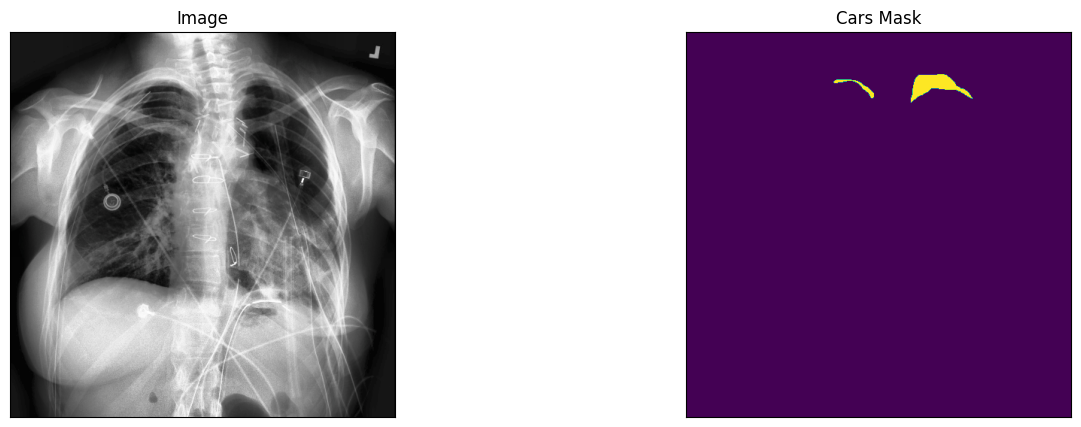

In [14]:
dataset =Dataset(
    root=root,
    images_dir=images_dir,
    masks_dir=masks_dir,
    csv=train_csv,
    aug_fn=augmentation_fn,
)
print(len(dataset))
image, mask = dataset[1] # get some sample
print(image.shape)
print(mask.shape)
print(np.unique(mask.squeeze()))
print(set(mask.flatten()))
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

In [15]:
# import torch
import numpy as np
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

/home/amog/segmentation-mlpr-2024/env_mlpr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
ENCODER = 'efficientnet-b4'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
epoch=-1
max_score=0
val_loss = 0
train_loss = 0
train_iou = 0
val_iou = 0

model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    activation=ACTIVATION,
).to(DEVICE)

# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = utils.losses.DiceLoss()
metrics = [
    utils.metrics.IoU(threshold=0.5)
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00375),
])

# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=10, T_mult=2)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=20, T_mult=1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=10, T_mult=1)

# print("Scheduler: ",scheduler.T_mult)

if resume:
    # checkpoint = torch.load('cosine/latest_model_cosine.pth')
    checkpoint = torch.load('cosine/model_epoch_99.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    print("Scheduler: ",scheduler.T_mult)
    epoch = checkpoint['epoch']
    loss = checkpoint['loss_function']
    max_score = checkpoint['max_score']
    val_loss = checkpoint['val_loss']
    train_loss = checkpoint['train_loss']
    train_iou = checkpoint['train_iou']
    val_iou = checkpoint['val_iou']
    print("Scheduler State Dict Now: ",checkpoint['scheduler_state_dict'])
    
    # scheduler.T_mult = 2
    #######
    # scheduler.T_mult = 1
    scheduler.T_0 = 10
    scheduler.T_i = 10
    # scheduler.base_lrs[0]/=2
    # scheduler._last_lr=scheduler.base_lrs
    # optimizer.param_groups[0]['lr']/=2
    #######

print("Scheduler State Dict Outside: ",scheduler.state_dict())        
print(epoch, loss, max_score, sep="\n")
print(f"Train Iou: {train_iou}\nValid Iou: {val_iou}\nTrain Loss: {train_loss}\nVal Loss: {val_loss}")
print(optimizer.param_groups[0]['lr'])
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Scheduler State Dict Outside:  {'T_0': 10, 'T_i': 10, 'T_mult': 1, 'eta_min': 0, 'T_cur': 0, 'base_lrs': [0.00375], 'last_epoch': 0, 'verbose': False, '_step_count': 0, '_get_lr_called_within_step': False, '_last_lr': [0.00375]}
-1
DiceLoss(
  (activation): Activation(
    (activation): Identity()
  )
)
0
Train Iou: 0
Valid Iou: 0
Train Loss: 0
Val Loss: 0
0.00375


In [17]:
print("Scheduler: ",scheduler.T_mult, scheduler.T_0) # o/p: 1 20

Scheduler:  1 10


In [18]:
train_dataset=Dataset(
    root=root,
    images_dir=images_dir,
    masks_dir=masks_dir,
    csv=train_csv,
    aug_fn=augmentation_fn,
    preprocessing_fn=get_preprocessing(preprocessing_fn)
)
print(len(train_dataset))

val_dataset=Dataset(
    root=root,
    images_dir=images_dir,
    masks_dir=masks_dir,
    csv=val_csv,
    aug_fn=augmentation_fn,
    preprocessing_fn=get_preprocessing(preprocessing_fn)
)

print(len(val_dataset))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
valid_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)

16845
1205


In [19]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [16]:
# # Scheduler Update Test
# iou_scores=[]
# train_iou_scores=[]
# dice_loss=[]

# for i in range(epoch+1, epoch+41):
    
#     print('\nEpoch: {}'.format(i))
    
#     print("Started with LR:",scheduler.get_last_lr())
#     scheduler.step()
#     print("Changed LR to:",scheduler.get_last_lr())
    
#     if scheduler.last_epoch%10==0:
#         scheduler.base_lrs[0]/=2
#         scheduler._last_lr=scheduler.base_lrs
#         print("Changed 20 Epoch Restart is:",scheduler.state_dict())

In [ ]:
iou_scores=[]
train_iou_scores=[]
dice_loss=[]

for i in range(epoch+1, epoch+11):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    train_iou_scores.append((i, train_logs['iou_score']))
    iou_scores.append((i, valid_logs['iou_score']))
    dice_loss.append((i, valid_logs['dice_loss']))
    
    print("Started with LR:",scheduler.get_last_lr())
    scheduler.step()
    print("Changed LR to:",scheduler.get_last_lr())
    
    if scheduler.last_epoch%10==0:
        scheduler.base_lrs[0]/=2
        scheduler._last_lr=scheduler.base_lrs
        
        print("Changed 10 Epoch Restart is:",scheduler.state_dict())

    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        print("best model!")

    checkpoint = {
        'epoch': i,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_function': loss,
        'max_score': max_score,
        'val_loss': valid_logs['dice_loss'],
        'train_loss': train_logs['dice_loss'],
        'train_iou': train_logs['iou_score'],
        'val_iou': valid_logs['iou_score'],
        'scheduler_state_dict': scheduler.state_dict()
    }

     wandb.log({"max_score": max_score,'val_loss': valid_logs['dice_loss'],
        'train_loss': train_logs['dice_loss'],
        'train_iou': train_logs['iou_score'],
        'val_iou': valid_logs['iou_score']})

    torch.save(checkpoint,f'cosine/model_epoch_{i}.pth')
    print("model saved!")
    
    if i == epoch+10:
        torch.save(checkpoint, 'cosine/latest_model_cosine.pth')
        print("latest model cosine saved!")
    
    np.savetxt(f'cosine/train_iou_scores_cosine14.txt',train_iou_scores,fmt='%.5f')
    np.savetxt(f'cosine/val_iou_scores_cosine14.txt',iou_scores,fmt='%.5f')
    np.savetxt(f'cosine/val_dice_loss_cosine13.txt',dice_loss,fmt='%.5f')
    
    
# np.savetxt(f'train_iou_scores_{i}.txt',train_iou_scores,fmt='%.5f')
# np.savetxt(f'val_iou_scores_{i}.txt',iou_scores,fmt='%.5f')
# np.savetxt(f'val_dice_loss_{i}.txt',dice_loss,fmt='%.5f')

    # if i == 25:
    #     optimizer.param_groups[0]['lr'] = 1e-5
    #     print('Decrease decoder learning rate to 1e-5!')


Epoch: 100
train:   8%|▊         | 173/2106 [02:44<29:55,  1.08it/s, dice_loss - 0.2976, iou_score - 0.5584]

In [ ]:
print("train iou:\n",train_iou_scores)
print()
print("val iou:\n",iou_scores)
print()
print("val loss:\n",dice_loss)